# Solución etapa 4 - Training - Predict

In [ ]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [58]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster


In [ ]:
version_to_load='v1'

In [ ]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path,'...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

In [ ]:
final_data.info()

In [ ]:
# Preparación del dato

final_data['Fecha'] = pd.to_datetime(final_data['Fecha'], format='%Y-%m-%d')


In [ ]:
target_column = 'Fallo'

## Extraemos un equipo

In [24]:
eq = 1
equipo = final_data[final_data['ID_Equipo'] == eq]

In [25]:
# Eliminar columnas innecesarias
equipo.drop(columns=['ID_Equipo'], inplace=True)

C:\Users\ricar\AppData\Local\Temp\ipykernel_19260\1548657718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipo.drop(columns=['ID_Equipo'], inplace=True)


In [26]:
# fecha como índice
equipo = equipo.set_index('Fecha')

In [27]:
# ïndices Duplicados
equipo[equipo.index.duplicated()]

,Vibracion_mm_s,Horas_Operativas,Fallo,Tipo_Equipo,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,
2021-09-29,5.167079,1,0.0,Bomba,Modelo_6,173,913
2024-01-11,4.272345,17,0.0,Bomba,Modelo_6,173,913


In [28]:
# Eliminar índices duplicados (mantener el primero)
equipo_clean = equipo[~equipo.index.duplicated(keep='first')]

equipo_clean[equipo_clean.index.duplicated()]

,Vibracion_mm_s,Horas_Operativas,Fallo,Tipo_Equipo,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,


In [29]:
# Convierte Timeseries a frecuencia especificada.
equipo_fq = equipo_clean.asfreq('D') 
equipo_fq = equipo_clean.sort_index()
equipo_fq.head()

,Vibracion_mm_s,Horas_Operativas,Fallo,Tipo_Equipo,Modelo,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,,
2021-01-01,2.136812,614,0.0,Bomba,Modelo_6,173,913
2021-01-03,1.529395,658,0.0,Bomba,Modelo_6,173,913
2021-01-04,3.411009,664,0.0,Bomba,Modelo_6,173,913
2021-01-05,0.618757,683,0.0,Bomba,Modelo_6,173,913
2021-01-06,4.641474,701,0.0,Bomba,Modelo_6,173,913


In [30]:
# Verificar que un índice temporal está completo

fecha_inicio = equipo_fq.index.min()
fecha_fin = equipo_fq.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=equipo_fq.index.freq)

print(f"Índice completo: {(equipo_fq.index == date_range_completo).all()}")

ValueError: Lengths must match to compare

## Separación datos train-test

Fechas train : 2021-01-01 00:00:00 --- 2024-09-12 00:00:00  (n=1350)
Fechas test  : 2024-09-13 00:00:00 --- 2024-12-31 00:00:00  (n=110)


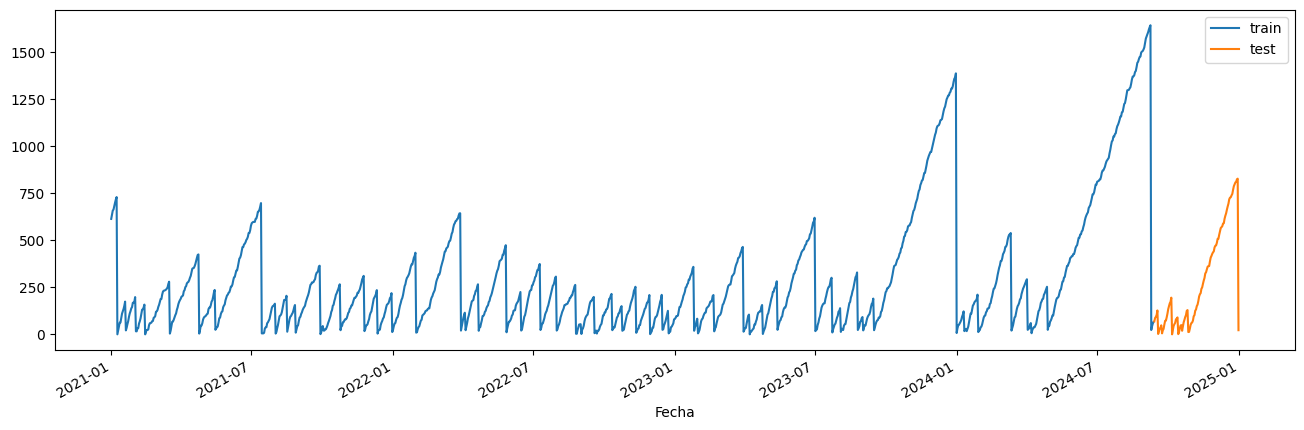

In [36]:
steps = 110
datos_train = equipo_fq[:-steps]
datos_test  = equipo_fq[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();

##  Forecasting autorregresivo recursivo

In [53]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=240
)

forecaster.fit(y=datos_train['Horas_Operativas'])
forecaster

d:\Program Files\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
d:\Program Files\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240] 
Window features: None 
Window size: 240 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 1349] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-23 12:21:24 
Last fit date: 2025-04-23 12:22:08 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

In [54]:
# Predicciones

predicciones = forecaster.predict(steps=steps)
predicciones.index = datos_test.index
predicciones

d:\Program Files\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1219: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


Fecha
2024-09-13     75.12
2024-09-14     88.03
2024-09-15     91.56
2024-09-16     94.81
2024-09-17     85.73
               ...  
2024-12-27    196.82
2024-12-28    197.62
2024-12-29    181.73
2024-12-30    186.87
2024-12-31    187.30
Name: pred, Length: 110, dtype: float64

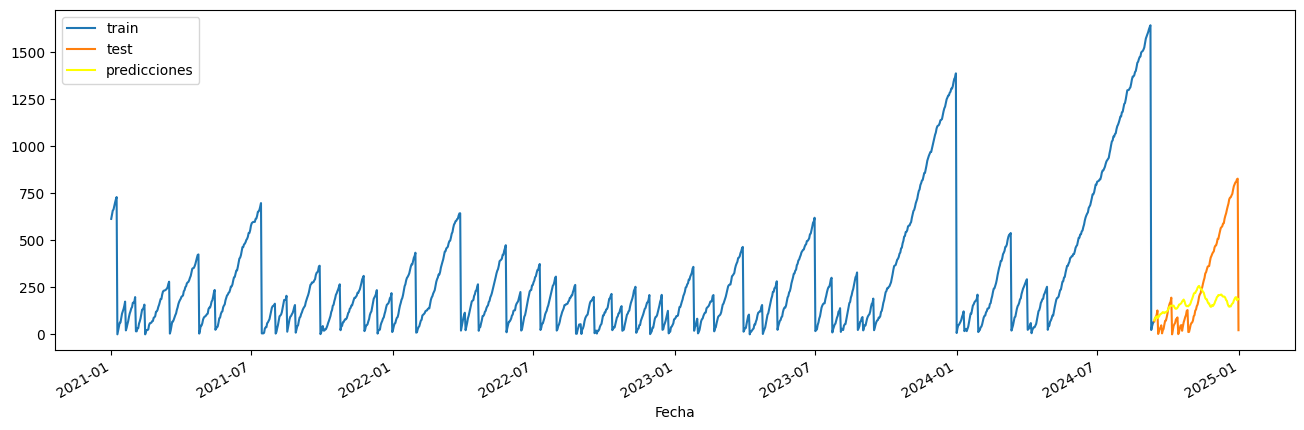

In [55]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color="yellow")
ax.legend()

In [57]:
# Error test

error_mse = mean_squared_error(
    y_true=datos_test['Horas_Operativas'],
    y_pred=predicciones
)

data_var = equipo_fq['Horas_Operativas'].var()

print(f"Error de test (mse): {error_mse}")
print(f"Varianza datos: {data_var}")
print(f"mse2var: {round(error_mse/data_var*100,2)}%")

Error de test (mse): 75584.56321090908
Varianza datos: 101702.70978433343
mse2var: 74.32%


In [ ]:
# Búsqueda de hiperparámetros: grid search

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=123),
    lags=12  # Este valor será remplazado en el grid search
)

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=int(len(datos_train) * 0.5),
    refit=False,
    fixed_train_size=False,

)

# Valores candidatos de lags
lags_grid = [100, 200]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=datos_train['Horas_Operativas'],
    cv=cv,
    param_grid=param_grid,
    lags_grid=lags_grid,
    metric='mean_squared_error',
    return_best=True,
    n_jobs='auto',
    verbose=False
)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

d:\Program Files\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
d:\Program Files\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1157: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
